# Homework 1

CS 637, Spring 2022

Due 3/3/21

1) Implement an API to create a fully-connected multilayer perceptron (MLP) for a *k*-class classification problem.

2) Test this implementation on MNIST data.

Notation

*  `w`: weights
*  `b`: biases
*  `z`: aggregated values
*  `a`: activated values
*  `x`: input to a neural network
*  `yhat`: output from a neural network (i.e., *after* softmax if applied)

In [1]:
# Install my API
!pip install -e mlp_api

Obtaining file:///C:/Users/RrbDellDesktop3/Documents/school/CS_637/hw1/mlp_api
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: mlp-api
    Found existing installation: mlp-api 0.1
    Uninstalling mlp-api-0.1:
      Successfully uninstalled mlp-api-0.1
  Running setup.py develop for mlp-api


In [1]:
import site
site.main()
from mlp_api import *

In [2]:
# Import other dependencies
import numpy as np
import gzip
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 6) # Set size of plots in notebook

# 1. API

In [ ]:
# TEMP: hinge loss bumbling
yhat = np.random.normal(size=(4,3)).T
y = np.zeros((4, 3)).T
y[0, 0] = 1
y[2, 1] = 1
y[1, 2] = 1
y[0, 3] = 1
yhat, y

In [ ]:
# TEMP
y_target = np.sum(np.where(y == 1, yhat, 0), axis=0)
dist = np.where(y == 1, 0, yhat - y_target + 1.)
maybe_deriv = np.where(y == 1, np.sum(dist > 0, axis=0), dist > 0)
dist, maybe_deriv

# 2. Testing the API

## 2.1 Import the MNIST dataset
*   Downloaded the four files from http://yann.lecun.com/exdb/mnist/.
*   Used `gzip` to read the files, then numpy to merge them again since splitting must be done my API.
*   Image ubyte files are offset by 16; labels by 8.


In [13]:
def read_gz(file, img_size=28, labels=False):
    f = gzip.open(file,'r')
    if labels:
        f.read(8)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8)
    else:
        f.read(16)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8).reshape(-1, img_size, img_size)

train_X = read_gz('mnist/train-images-idx3-ubyte.gz')
train_y = read_gz('mnist/train-labels-idx1-ubyte.gz', labels=True)
test_X = read_gz('mnist/t10k-images-idx3-ubyte.gz')
test_y = read_gz('mnist/t10k-labels-idx1-ubyte.gz', labels=True)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [15]:
mnist_all_X = np.concatenate((train_X, test_X), axis=0)
mnist_all_y = np.concatenate((train_y, test_y), axis=0)
print('MNIST features reshaped:', mnist_all_X.shape, 
      '\nMNIST labels reshaped:', mnist_all_y.shape)

MNIST features reshaped: (70000, 28, 28) 
MNIST labels reshaped: (70000,)


## 2.2 Preprocessing

Feature and label shapes: (784, 70000) (10, 70000)


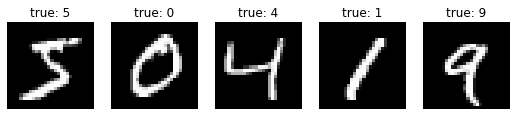

In [16]:
# Make a Dataset object
mnist_set = Dataset(mnist_all_X, mnist_all_y)

# Reshape the data
width = 28
categories = 10
mnist_set.shape(width, categories)
print("Feature and label shapes:", mnist_set.X.shape, mnist_set.y.shape)

# Visualize the first five images
Utility.plot_images(mnist_set, 5)

Splits on training, validation, & testing: (784, 49000) (784, 10500) (784, 10500)


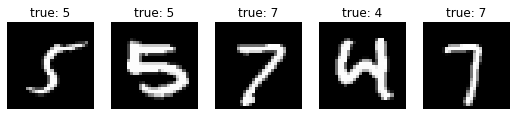

In [17]:
# Shuffle the data
mnist_set.shuffle()
Utility.plot_images(mnist_set, 5)

# Divide the data
mnist_set.divide()
print('Splits on training, validation, & testing:', 
      mnist_set.X_train.shape, mnist_set.X_valid.shape, mnist_set.X_test.shape)

## 2.3 Training and validation

In [19]:
# Hyperparameters to use throughout all models
batch = 100
epochs = 15

### 2.3.1 Varying the learning rate

In [20]:
dims = (width*width, 128, 64, 10)
activ_fns = (Activation.relu, Activation.relu, Activation.softmax)

# Make a generic neural network with two hidden layers
p_128_64 = Perceptron(dims, activ_fns, Loss.cross_entropy)

# Different learning rates to test
lr_results = {}
lrs = (5e-4, 0.002, 0.01)
for lr in lrs:
  p_128_64.reset() # Reinitialize parameters
  lr_results[lr] = Utility.train_epochs(p_128_64, mnist_set, lr, epochs, batch)

Epoch 	Train_loss 	Train_acc
0 	    3.500 	    0.161
1 	    2.019 	    0.389
2 	    1.525 	    0.523
3 	    1.279 	    0.595
4 	    1.128 	    0.642
5 	    1.023 	    0.676
6 	    0.945 	    0.701
7 	    0.885 	    0.721
8 	    0.837 	    0.737
9 	    0.798 	    0.751
10 	    0.765 	    0.763
11 	    0.737 	    0.771
12 	    0.713 	    0.780
13 	    0.692 	    0.787
14 	    0.673 	    0.794
Time elapsed (s): 22.9

Epoch 	Train_loss 	Train_acc


KeyboardInterrupt: 

In [ ]:
# Plot training loss for the different learning rates used
Utility.plot_results([lr_results[_][0] for _ in lrs],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Cross-entropy loss',
                     title='Effect of learning rate on training loss')

In [ ]:
# Plot training accuracy for the different learning rates used
Utility.plot_results([lr_results[_][1] for _ in lrs],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Accuracy', ymax=1.0,
                     title='Effect of learning rate on accuracy')

In [ ]:
# Visualize images from a random sample
Utility.plot_images(mnist_set, 20, True, p_128_64)

### 2.3.2 Changing the architecture

*   Number of hidden layers
*   Number of neurons per layer



In [ ]:
# Define different architectures to try
arch_results = {}
lr = 0.001
dims_set = ((width*width, 64, 32, 10),
            (width*width, 256, 128, 10), 
            (width*width, 256, 128, 64, 10))
activ_fns_set = ((Activation.relu, Activation.relu, Activation.softmax),
                 (Activation.relu, Activation.relu, Activation.softmax),
                 (Activation.relu, Activation.relu, Activation.relu, Activation.softmax))

In [ ]:
# Train models, validate
for dims, activ_fns in zip(dims_set, activ_fns_set):
  p = Perceptron(dims, activ_fns, Loss.cross_entropy)
  arch_results[dims] = Utility.train_and_validate(p, mnist_set, 
                                                  lr, epochs, batch)

In [ ]:
# Plot loss for the different architectures tried
Utility.plot_results([arch_results[_][0] for _ in dims_set],
                     labels=[str(dims) + ', testing' for dims in dims_set],
                     fmts=['-' + _ for _ in ('b', 'r', 'g')])

Utility.plot_results([arch_results[_][2] for _ in dims_set],
                     labels=[str(dims[1:]) + ', validation' for dims in dims_set],
                     fmts=['.' + _ for _ in ('b', 'r', 'g')],
                     ylabel='Cross-entropy loss', ymax=4.0,
                     title='Effect of architecture on loss')

In [ ]:
# Plot accuracy for different architectures tried
Utility.plot_results([arch_results[_][1] for _ in dims_set],
                     labels=[str(dims) + ', testing' for dims in dims_set],
                     fmts=['-' + _ for _ in ('b', 'r', 'g')])
Utility.plot_results([arch_results[_][3] for _ in dims_set],
                     labels=[str(dims) + ', validation' for dims in dims_set],
                     fmts=['.' + _ for _ in ('b', 'r', 'g')],
                     ylabel='Accuracy', ymax=1.0,
                     title='Effect of architecture on accuracy')

## 2.4 Testing

Report performance by passing the test set through a trained model.

In [ ]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = p_128_64.train(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.3f}'.format(loss, acc))

# 3. Appendix

Simple tests to check basic functionality with hand calculations.

Hinge loss examples from class on 1/20/22

In [21]:
# 3-class classification example
ex1 = np.array([-3.7, 5, 7]).T
print('Target class is 3, loss={:0.1f} \tif 2, {:0.1f} \tif 1, {:0.1f}'.format(
    Loss.hinge_loss(ex1, np.array([0, 0, 1]).T),
    Loss.hinge_loss(ex1, np.array([0, 1, 0]).T),
    Loss.hinge_loss(ex1, np.array([1, 0, 0]).T)))

Target class is 3, loss=0.0 	if 2, 3.0 	if 1, 21.4


In [22]:
# 4-class classification example
ex2 = np.array([2.5, 2.0, 2.7, 1.7]).T
print('Target class is 2: {:0.1f}'.format(
    Loss.hinge_loss(ex2, np.array([0, 1, 0, 0]).T)))

Target class is 2: 3.9


Compute accuracy on two examples, one predicted correctly and one not:

In [23]:
yhat = np.array(((0.2, 0.5, 0.3), (0.7, 0.2, 0.1))).T
y = np.array(((0, 1, 0), (0, 1, 0))).T
Loss.accuracy(yhat, y)

0.5

Informal problem given at the end of class, 1/25/22:

In [30]:
p = Perceptron((4, 3, 2, 4), 
               (Activation.relu, Activation.sigmoid, Activation.softmax), 
               Loss.cross_entropy, init_with_normal=True)
p[1].w = np.array([[1.,0,0,0], [0,1,0,0], [0,0,1,0]])
p[2].w = np.array([[1.,0,0], [0,1,0]])
p[3].w = np.array([[1.,0], [0,1], [0,0], [0,0]])
p.zero_biases()

# Check forward path
p.forward(np.array([1, 0, 1, 0]).reshape(-1, 1), batch_size=1)
for i in range(1, len(p.dims)):
  print('Layer', i, '\nz =\n', p[i].z, '\na =\n', p[i].a, '\n')

Layer 1 
z =
 [[1.]
 [0.]
 [1.]] 
a =
 [[1.]
 [0.]
 [1.]] 

Layer 2 
z =
 [[1.]
 [0.]] 
a =
 [[0.73105858]
 [0.5       ]] 

Layer 3 
z =
 [[0.73105858]
 [0.5       ]
 [0.        ]
 [0.        ]] 
a =
 [[0.36278004]
 [0.28793597]
 [0.17464199]
 [0.17464199]] 



In [38]:
# Check backpropagation
y = np.array([0., 1., 0., 0.]).reshape(-1, 1) # Dummy one-hot label
print('p[1].w before backprop\n', p[1].w)
p.backward(y, lr=0.5, batch_size=1)
print('p[1].w after backprop\n', p[1].w)
print('New output:', Activation.softmax(p[3].w @ p[2].a + p[3].b))

p[1].w before backprop
 [[20.64794602  0.         19.64794602  0.        ]
 [ 4.94097879  1.          4.94097879  0.        ]
 [17.33730994  0.         18.33730994  0.        ]]
p[1].w after backprop
 [[30.47285289  0.         29.47285289  0.        ]
 [ 5.99665499  1.          5.99665499  0.        ]
 [26.32064505  0.         27.32064505  0.        ]]
New output: [[5.85118834e-04]
 [9.97257193e-01]
 [1.07884427e-03]
 [1.07884427e-03]]
